In [ ]:
# Import essential libraries
import os
import joblib
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from numpy.random import rand
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from random import randrange
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
import xgboost as xg

In [ ]:
# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# import datasets
train_df = pd.read_csv('02.desharnais.csv')
#test_df = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
#submission = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

# converting column without decimal to integer
for col in train_df.columns:
    if np.sum((train_df[col] - train_df[col].astype('int'))) == 0:
        train_df[col] = train_df[col].astype('int')

#for col in test_df.columns:
#    if np.sum((test_df[col] - test_df[col].astype('int'))) == 0:
#        test_df[col] = test_df[col].astype('int')

In [ ]:
train_df.head()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language
0,1,1,1,4,85,12,5152,253,52,305,34,302,1
1,2,2,0,0,86,4,5635,197,124,321,33,315,1
2,3,3,4,4,85,1,805,40,60,100,18,83,1
3,4,4,0,0,86,5,3829,200,119,319,30,303,1
4,5,5,0,0,86,4,2149,140,94,234,24,208,1


In [ ]:
print(f'Number of rows: {train_df.shape[0]};  Number of columns: {train_df.shape[1]}; No of missing values: {sum(train_df.isna().sum())}')

Number of rows: 81;  Number of columns: 13; No of missing values: 0


In [ ]:
train_df.dtypes

id                 int64
Project            int64
TeamExp            int64
ManagerExp         int64
YearEnd            int64
Length             int64
Effort             int64
Transactions       int64
Entities           int64
PointsNonAdjust    int64
Adjustment         int64
PointsAjust        int64
Language           int64
dtype: object

In [ ]:
train_df.describe()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,41.000000,2.185185,2.530864,85.740741,11.666667,5046.308642,182.123457,122.333333,304.456790,27.629630,289.234568,1.555556
std,23.526581,23.526581,1.415195,1.643825,1.222475,7.424621,4418.767228,144.035098,84.882124,180.210159,10.591795,185.761088,0.707107
min,1.000000,1.000000,-1.000000,-1.000000,82.000000,1.000000,546.000000,9.000000,7.000000,73.000000,5.000000,62.000000,1.000000
25%,21.000000,21.000000,1.000000,1.000000,85.000000,6.000000,2352.000000,88.000000,57.000000,176.000000,20.000000,152.000000,1.000000
50%,41.000000,41.000000,2.000000,3.000000,86.000000,10.000000,3647.000000,140.000000,99.000000,266.000000,28.000000,255.000000,1.000000
75%,61.000000,61.000000,4.000000,4.000000,87.000000,14.000000,5922.000000,224.000000,169.000000,384.000000,35.000000,351.000000,2.000000
max,81.000000,81.000000,4.000000,7.000000,88.000000,39.000000,23940.000000,886.000000,387.000000,1127.000000,52.000000,1116.000000,3.000000


In [ ]:
X_train = train_df.drop(['id'], axis=1).values
y_train = train_df['Effort'].values

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (81, 12)
Shape of y_train: (81,)


In [ ]:
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    # number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain = xt[:, x == 1]
    ytrain = yt.reshape(num_train)
    xvalid = xv[:, x == 1]
    yvalid = yv.reshape(num_valid)
    # Training
    mdl     = LinearRegression()
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    error   = mean_squared_error(yvalid, ypred, squared=False)

    return error

In [ ]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)

    return cost

In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()

    return X

In [ ]:
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]

    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()

    return V, Vmax, Vmin

In [ ]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0

    return Xbin

In [ ]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub

    return x

In [ ]:
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor

    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2']

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')

    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim)

    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float')
    t     = 0

    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)

        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]

        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1

        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d])
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])


    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim)
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}

    return pso_data

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [ ]:
c1  = 2         # cognitive factor
c2  = 2         # social factor
w   = 0.9       # inertia weight
k     = 5     # k-value in KNN
N     = 20    # number of population
T     = 100   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

Iteration: 1
Best (PSO): 0.0033333333356482565
Iteration: 2
Best (PSO): 0.0025000000015359693
Iteration: 3
Best (PSO): 0.0025000000015359693
Iteration: 4
Best (PSO): 0.0025000000015359693
Iteration: 5
Best (PSO): 0.0016666666683122088
Iteration: 6
Best (PSO): 0.0016666666683122088
Iteration: 7
Best (PSO): 0.0016666666683122088
Iteration: 8
Best (PSO): 0.0016666666683122088
Iteration: 9
Best (PSO): 0.0016666666683122088
Iteration: 10
Best (PSO): 0.0016666666683122088
Iteration: 11
Best (PSO): 0.0016666666683122088
Iteration: 12
Best (PSO): 0.0016666666683122088
Iteration: 13
Best (PSO): 0.0016666666683122088
Iteration: 14
Best (PSO): 0.0016666666683122088
Iteration: 15
Best (PSO): 0.0016666666682236047
Iteration: 16
Best (PSO): 0.0016666666682236047
Iteration: 17
Best (PSO): 0.0016666666682236047
Iteration: 18
Best (PSO): 0.000833333334751285
Iteration: 19
Best (PSO): 0.000833333334751285
Iteration: 20
Best (PSO): 0.000833333334751285
Iteration: 21
Best (PSO): 0.000833333334751285
Itera

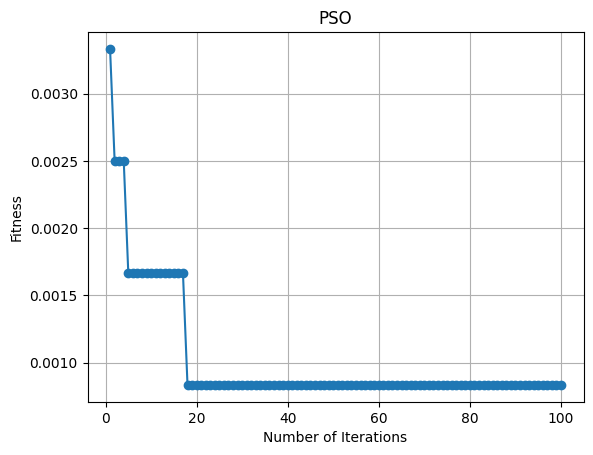

In [ ]:
# perform feature selection
start_time = time.time()
fmdl  = jfs(X_train, y_train, opts)
print("Run Time --- %s seconds ---" % (time.time() - start_time))

sf    = fmdl['sf']

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = LinearRegression()
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
RMSE       = mean_squared_error(y_valid, y_pred, squared=False)
print("RMSE:", RMSE)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [ ]:
fmdl['sf']

array([5])

In [ ]:
X_test = train_df.drop(['id'], axis=1).values
X_test   = X_test[:, sf]
sc = StandardScaler()
X_test = sc.fit_transform(X_test)